In [1]:
%cd ..

/home/eli/AnacondaProjects/ppc_experiments


In [2]:
import argparse
import collections
import numpy as np
import pyro
import torch
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
import trainer.trainer as module_trainer

In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [5]:
from utils import read_json

config = read_json("experiments/ppc_mnist_config.json")
config = ConfigParser(config)

In [6]:
logger = config.get_logger('train')

# setup data_loader instances
data_loader = config.init_obj('data_loader', module_data)
valid_data_loader = data_loader.split_validation()

# build model architecture, then print to console
model = config.init_obj('arch', module_arch)
logger.info(model)

# get function handles of metrics
metrics = [getattr(module_metric, met) for met in config['metrics']]

# build optimizer.
optimizer = config.init_obj('optimizer', pyro.optim)

# build trainer
# kwargs = config['trainer'].pop('args')
trainer = config.init_obj('trainer', module_trainer, model, metrics, optimizer,
                          config=config, data_loader=data_loader,
                          valid_data_loader=valid_data_loader,
                          lr_scheduler=None)

trainer._resume_checkpoint("saved/models/Mnist_Ppc/0222_160001/checkpoint-epoch1000.pth")

MnistPpc(
  (digit_features): DigitFeatures()
  (decoder): DigitDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=200, bias=True)
      (1): ReLU()
      (2): Linear(in_features=200, out_features=400, bias=True)
      (3): ReLU()
      (4): Linear(in_features=400, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
  (graph): GraphicalModel()
)
Trainable parameters: 396984
Initialize particles: train batch 0
Initialize particles: train batch 1
Initialize particles: train batch 2
Initialize particles: train batch 3
Initialize particles: train batch 4
Initialize particles: train batch 5
Initialize particles: train batch 6
Initialize particles: train batch 7
Initialize particles: train batch 8
Initialize particles: train batch 9
Initialize particles: train batch 10
Initialize particles: train batch 11
Initialize particles: train batch 12
Initialize particles: train batch 13
Initialize particles: train batch 14
Initialize particles: train batch 15
I

In [7]:
trainer.model.eval()
trainer.cpu()
trainer.valid_particles.cpu()

ParticleDict(  (z_what): Parameter containing: [torch.FloatTensor of size 8x6000x1x10])

In [8]:
trainer._load_particles(range(trainer.data_loader.batch_size), False)

In [9]:
for site in trainer.model.graph.nodes:
    trainer.model.graph.nodes[site]['is_observed'] = trainer.model.graph.nodes[site]['value'] is not None

In [10]:
import utils

In [11]:
with pyro.plate_stack("forward", (trainer.num_particles, trainer.data_loader.batch_size)):
    model = pyro.condition(trainer.model, data={k: v['value'] for k, v in trainer.model.graph.nodes.items()})
    xs = model()

In [12]:
import matplotlib.pyplot as plt

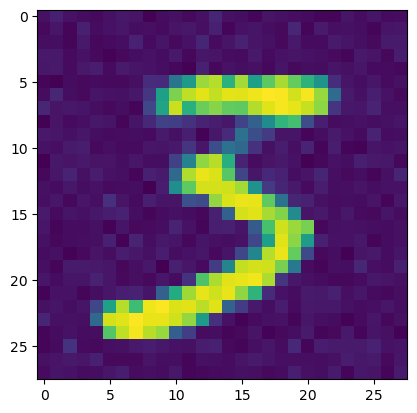

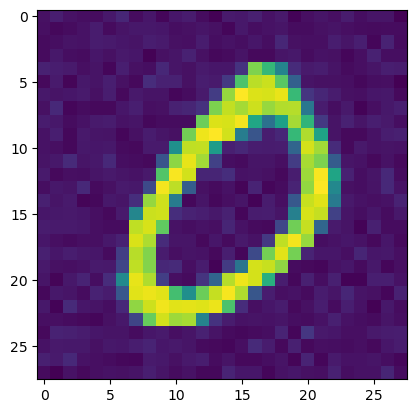

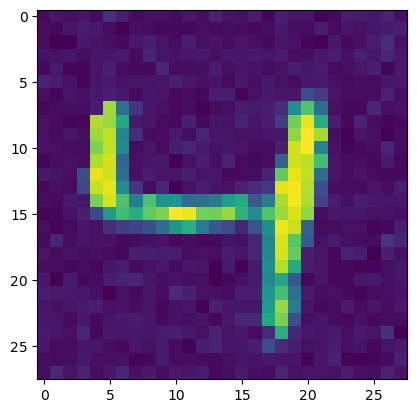

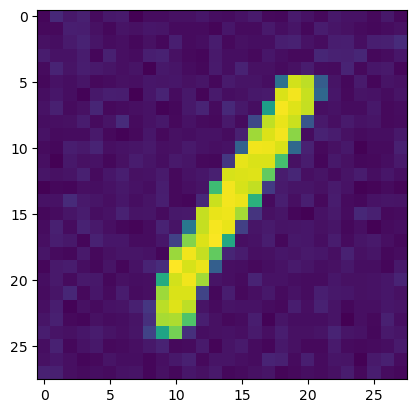

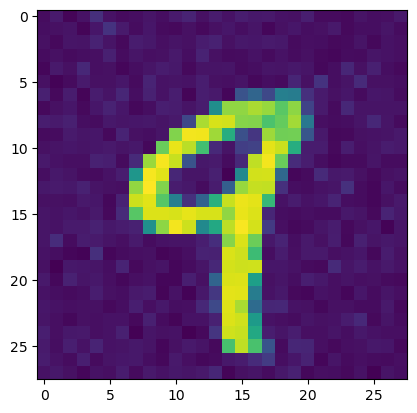

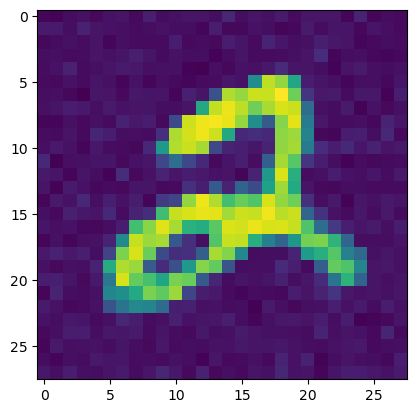

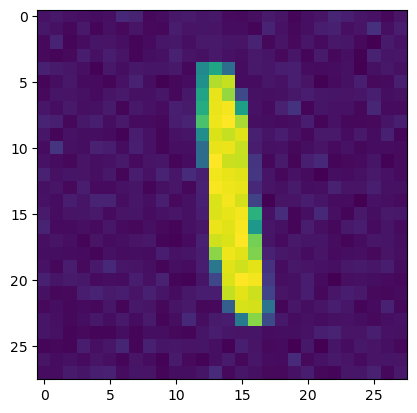

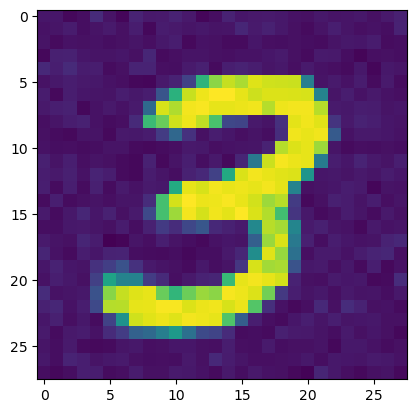

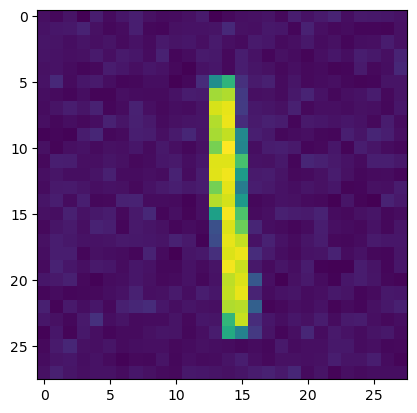

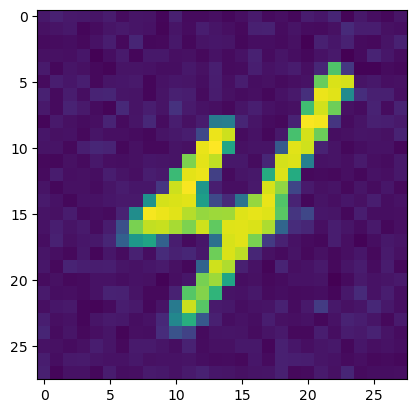

In [13]:
for i in range(10):
    plt.imshow(xs.mean(dim=0)[i].squeeze().detach().numpy())
    plt.show()